### 개, 고양이 데이터 세트의 디렉토리와 파일을 기반으로 메타 정보용 DF 생성

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
!gdown --id 1MP5IVX30XcYqN5RHwBKPdWLEvRfXLH71

Mounted at /gdrive
Downloading...
From: https://drive.google.com/uc?id=1MP5IVX30XcYqN5RHwBKPdWLEvRfXLH71
To: /content/catanddog.zip
228MB [00:02, 76.6MB/s]


In [ ]:
!unzip catanddog.zip

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
# DF 생성 함수
# os.walk()를 이용하여 특정 디렉토리 밑에 있는 하위 디렉토리를 읽는다.
# 해당 디렉토리의 jpg 확장자를 가진 모든 파일 읽기
def make_catndog_dataframe():
    paths = []
    dataset_gubnus = []
    label_gubuns = []
    for dirname, _, filenames in os.walk('cat-and-dog'):
        #print(dirname)
        for filename in filenames:
            if '.jpg' in filename:                              # .jpg가 들어있으면 그것만 가져오기
                #파일 정대 경로를 file_path 변수에 할당
                file_path = dirname + '/' + filename
                paths.append(file_path)
                # 파일 절대 경로에 training_set, test_set 포함되어 있으면 데이터셋 구분을 'train', 'test' 분류
                if '/training_set' in file_path:
                    dataset_gubnus.append('train')
                elif '/test_set/' in file_path:
                    dataset_gubnus.append('test')
                #이도 저도 아니면 짝을 맞추기 위해 N/A 넣기
                else:
                    dataset_gubnus.append('N/A') 
                #파일의 정대 경로에 dogs가 있을 경우 dog, cats가 있을 경우 cat라고 레이블 분류
                if 'dogs' in file_path:
                    label_gubuns.append('DOG')
                elif 'cats' in file_path:
                    label_gubuns.append('CAT')
                else:
                    label_gubuns.append('N/A')
    data_df = pd.DataFrame({'path':paths, 'dataset': dataset_gubnus, 'label':label_gubuns})
    return data_df

In [ ]:
#col 생략 안되고 보기
pd.set_option('display.max_colwidth', 200)
data_df = make_catndog_dataframe()
print('data_df shape: ', data_df.shape)
data_df.head()

data_df shape:  (10028, 3)


,path,dataset,label
0,cat-and-dog/test_set/cats/cat.4798.jpg,test,CAT
1,cat-and-dog/test_set/cats/cat.4486.jpg,test,CAT
2,cat-and-dog/test_set/cats/cat.4389.jpg,test,CAT
3,cat-and-dog/test_set/cats/cat.4130.jpg,test,CAT
4,cat-and-dog/test_set/cats/cat.4171.jpg,test,CAT


In [ ]:
# Keras Sequence를 상속 받은 Dataset객체를 생성
from tensorflow.keras.utils import Sequence
import sklearn
import cv2

# 배치 크기와 이미지 크기 변수 선언
BATCH_SIZE = 64
IMAGE_SIZE = 224

class CnD_Dataset(Sequence):
  # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당
  def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False):
    '''
    image_filenames : image를 로드할 파일의 절대 경로
    labels : 해당 이미지의 label
    batch_size : __getitem__(self, index) 호출 시 마다 가져올 batch건수
    augmentor : albumentations 객체
    shuffle: 학습 데이터의 경우 epoch 종료시마다 데이타를 섞을지 여부
    '''
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.augmentor = augmentor
    self.shuffle = shuffle

  # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함.
  # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size 단위로 몇번 데이터를 반환하는지 나타냄
  def __len__(self):
    # batch_size단위로 데이터를 몇번 가져와야하는지 계산, 전체 데이터 건수를 batch_size로 나누되, 
    # 정수로 정확히 나줘 지지 않을 경우 1회를 더한다.
    return int(np.ceil(len(self.labels)/self.batch_size))

  def __getitem__(self, index):
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이터를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환

    image_name_batch = self.image_filenames[index * self.batch_size:(index+1) * self.batch_size]
    if self.labels is not None:
      label_batch = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
    
    image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
    for image_index in range(image_name_batch.shape[0]):
      image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
      if self.augmentor is not None:
        image = self.augmentor(image=image)['image']
      image_batch[image_index] = image
    return image_batch, label_batch
    
  def on_epoch_end(self):
    # epoch각 한번 수행 완료 될 때마다 모델의 fit()에서 호출 함.
    if (self.shuffle):
      self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
    else:
      pass

In [ ]:
# local에서 실행시
# !pip list albumentations : 유무 확인
# !pip install albumentations :없으면 설치

# Sequence 기반 Dataset을 생성하고 호출하기
# - albumentations를 이용하여 batch크기 만큼 데이터를 augumentation한 뒤 
#   데이터를 반환할 수 있는 Sequence 기반 dataset을 생성하고 호출
data_df.head()

,path,dataset,label
0,cat-and-dog/test_set/cats/cat.4798.jpg,test,CAT
1,cat-and-dog/test_set/cats/cat.4486.jpg,test,CAT
2,cat-and-dog/test_set/cats/cat.4389.jpg,test,CAT
3,cat-and-dog/test_set/cats/cat.4130.jpg,test,CAT
4,cat-and-dog/test_set/cats/cat.4171.jpg,test,CAT


In [ ]:
import albumentations as A
# 전체 데이터 세트에서 학습과 테스트용 생성
train_df = data_df[data_df['dataset'] == 'train']
test_df = data_df[data_df['dataset'] == 'test']
# image file의 위치가 있는 데이터와 label값을 numpy array로 변환
train_image_filenames = train_df['path'].values
train_image_labels = train_df['label'].values
cnd_augmentor = A.Compose([
                           A.HorizontalFlip(p=0.5),
                           A.VerticalFlip(p=0.5),
                           A.ShiftScaleRotate(p=0.5)
                          ])
# Sequence 를 상속받은 CnD_Dataset을 image 파일 위치, label값, albumentations 변환 객체를 입력, 생성
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False)

In [ ]:
train_image_filenames.shape

(8005,)

In [ ]:
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0])

(64, 224, 224, 3) (64,)
[[[ 25.  44.  53.]
  [112. 121. 121.]
  [158. 159. 153.]
  ...
  [185. 142. 128.]
  [166. 108. 105.]
  [178. 117. 124.]]

 [[ 24.  44.  52.]
  [112. 122. 121.]
  [162. 163. 157.]
  ...
  [179. 136. 123.]
  [165. 107. 104.]
  [177. 117. 124.]]

 [[ 25.  42.  50.]
  [115. 122. 122.]
  [164. 165. 159.]
  ...
  [174. 131. 115.]
  [162. 107. 101.]
  [177. 117. 125.]]

 ...

 [[130. 131. 120.]
  [157. 166. 162.]
  [115. 125. 127.]
  ...
  [  3.   3.   5.]
  [  3.   4.   6.]
  [  1.   1.   0.]]

 [[135. 137. 125.]
  [163. 171. 168.]
  [113. 122. 124.]
  ...
  [  1.   1.   3.]
  [  2.   1.   3.]
  [  6.   4.   2.]]

 [[134. 135. 124.]
  [163. 171. 168.]
  [114. 124. 126.]
  ...
  [  8.   8.  10.]
  [ 12.  12.  14.]
  [ 12.   8.   7.]]]


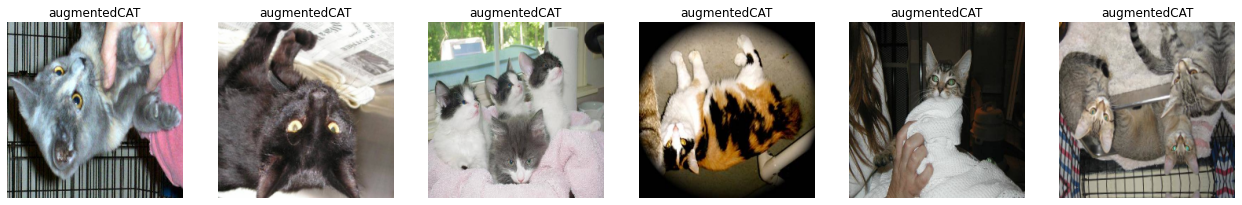

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_grid_images(images_batch, ncols=4, title=None):
    figure, axs = plt.subplots(figsize=(22,4), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(np.array(images_batch[i], dtype='int32'))
        axs[i].axis('off')
        axs[i].set_title(title[i])
show_grid_images(images_batch, ncols=6, title='augmented' + labels_batch)

In [ ]:
# 원본 이미지 픽셀값을 0~1로 스케일링

# Keras Sequence를 상속 받은 Dataset객체를 생성
from tensorflow.keras.utils import Sequence
import sklearn
import cv2

# 배치 크기와 이미지 크기 변수 선언
BATCH_SIZE = 64
IMAGE_SIZE = 224

class CnD_Dataset(Sequence):
  # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당
  def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False):
    '''
    image_filenames : image를 로드할 파일의 절대 경로
    labels : 해당 이미지의 label
    batch_size : __getitem__(self, index) 호출 시 마다 가져올 batch건수
    augmentor : albumentations 객체
    shuffle: 학습 데이터의 경우 epoch 종료시마다 데이타를 섞을지 여부
    '''
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.augmentor = augmentor
    self.shuffle = shuffle

  # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함.
  # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size 단위로 몇번 데이터를 반환하는지 나타냄
  def __len__(self):
    # batch_size단위로 데이터를 몇번 가져와야하는지 계산, 전체 데이터 건수를 batch_size로 나누되, 
    # 정수로 정확히 나줘 지지 않을 경우 1회를 더한다.
    return int(np.ceil(len(self.labels)/self.batch_size))

  def __getitem__(self, index):
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이터를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환

    image_name_batch = self.image_filenames[index * self.batch_size:(index+1) * self.batch_size]
    if self.labels is not None:
      label_batch = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
    
    image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
    for image_index in range(image_name_batch.shape[0]):
      image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
      if self.augmentor is not None:
        image = self.augmentor(image=image)['image']
        # 이미지 픽셀 값을 0~1로 스케일링
        image = image/255.
      image_batch[image_index] = image
    return image_batch, label_batch
    
  def on_epoch_end(self):
    # epoch각 한번 수행 완료 될 때마다 모델의 fit()에서 호출 함.
    if (self.shuffle):
      self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
    else:
      pass

(64, 224, 224, 3) (64,)
[[[[0.69803922 0.45882353 0.48627451]
   [0.65098039 0.42352941 0.41176471]
   [0.7254902  0.55686275 0.50196078]
   ...
   [0.61960784 0.62352941 0.6       ]
   [0.43921569 0.4745098  0.4745098 ]
   [0.09803922 0.17254902 0.20784314]]

  [[0.69411765 0.45882353 0.48627451]
   [0.64705882 0.41960784 0.40784314]
   [0.70196078 0.53333333 0.48235294]
   ...
   [0.63529412 0.63921569 0.61568627]
   [0.43921569 0.47843137 0.4745098 ]
   [0.09411765 0.17254902 0.20392157]]

  [[0.69411765 0.45882353 0.49019608]
   [0.63529412 0.41960784 0.39607843]
   [0.68235294 0.51372549 0.45098039]
   ...
   [0.64313725 0.64705882 0.62352941]
   [0.45098039 0.47843137 0.47843137]
   [0.09803922 0.16470588 0.19607843]]

  ...

  [[0.00392157 0.00392157 0.        ]
   [0.01176471 0.01568627 0.02352941]
   [0.01176471 0.01176471 0.01960784]
   ...
   [0.45098039 0.49019608 0.49803922]
   [0.61568627 0.65098039 0.63529412]
   [0.50980392 0.51372549 0.47058824]]

  [[0.02352941 0.0156

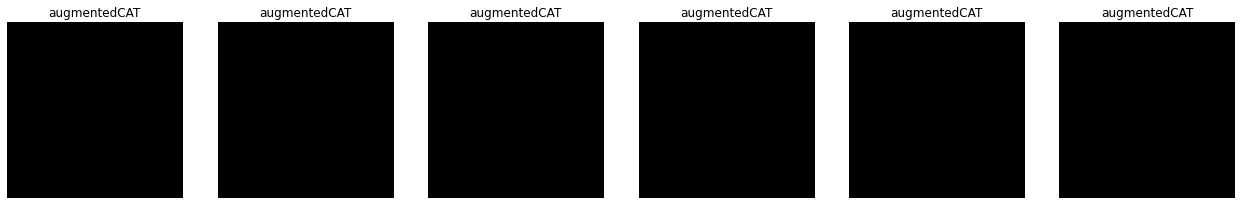

In [ ]:
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:2])

show_grid_images(images_batch, ncols=6, title='augmented' + labels_batch)

In [ ]:
# Pretrained 모델에서 사용하는 보다 범용적인 preprocessing을 적용할 수 있도록 수정
# - pre_func 인자를 추가 -> pretrained 모델의 preprocess_input 함수를 인자로 입력할 수 있도록 구성

class CnD_Dataset(Sequence):
  # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당
  def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
    '''
    image_filenames : image를 로드할 파일의 절대 경로
    labels : 해당 이미지의 label
    batch_size : __getitem__(self, index) 호출 시 마다 가져올 batch건수
    augmentor : albumentations 객체
    shuffle: 학습 데이터의 경우 epoch 종료시마다 데이타를 섞을지 여부
    '''
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.augmentor = augmentor
    self.shuffle = shuffle
    self.pre_func = pre_func

  # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함.
  # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size 단위로 몇번 데이터를 반환하는지 나타냄
  def __len__(self):
    # batch_size단위로 데이터를 몇번 가져와야하는지 계산, 전체 데이터 건수를 batch_size로 나누되, 
    # 정수로 정확히 나줘 지지 않을 경우 1회를 더한다.
    return int(np.ceil(len(self.labels)/self.batch_size))

  def __getitem__(self, index):
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이터를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환

    image_name_batch = self.image_filenames[index * self.batch_size:(index+1) * self.batch_size]
    if self.labels is not None:
      label_batch = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
    
    image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
    for image_index in range(image_name_batch.shape[0]):
      image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
      if self.augmentor is not None:
        image = self.augmentor(image=image)['image']
        # 이미지 픽셀 값을 0~1로 스케일링
        # image = image/255.
      if self.pre_func is not None:
        image = self.pre_func(image)
      image_batch[image_index] = image
    return image_batch, label_batch
    
  def on_epoch_end(self):
    # epoch각 한번 수행 완료 될 때마다 모델의 fit()에서 호출 함.
    if (self.shuffle):
      self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
    else:
      pass

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False, pre_func = xcp_preprocess_input)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:1])

(64, 224, 224, 3) (64,)
[[[[-0.29411763 -0.23137254 -0.18431371]
   [-0.41176468 -0.36470586 -0.23921567]
   [-0.50588238 -0.45098037 -0.372549  ]
   ...
   [ 0.70980394  0.45098042  0.34117651]
   [ 0.58431375  0.28627455  0.21568632]
   [ 0.58431375  0.26274514  0.21568632]]

  [[-0.67058825 -0.6156863  -0.59215689]
   [-0.68627453 -0.63921571 -0.53725493]
   [-0.57647061 -0.51372552 -0.4588235 ]
   ...
   [ 0.7019608   0.48235297  0.35686278]
   [ 0.65490198  0.39607847  0.30980396]
   [ 0.50588238  0.19215691  0.13725495]]

  [[-0.11372548 -0.05098039 -0.05882353]
   [-0.0745098   0.01176476  0.07450986]
   [-0.04313725  0.05882359  0.09019613]
   ...
   [ 0.70980394  0.50588238  0.37254906]
   [ 0.7019608   0.48235297  0.38823533]
   [ 0.49019611  0.20000005  0.14509809]]

  ...

  [[ 0.09803927  0.09803927  0.03529418]
   [-0.8509804  -0.83529413 -0.86666667]
   [-0.48235291 -0.41960782 -0.41960782]
   ...
   [-1.         -0.81960785 -0.68627453]
   [-0.99215686 -0.89019608 -0.84

In [ ]:
# 별도의 preprocessing 함수나 albumentations의 normalize 적용해보기

#pre_func를 zero_one_scaler로 지정해주면 minmax scale이 됨
def zero_one_scaler(image):
    return image/255.

# 내 루틴에 맞게 pre_func 사용하면 됨
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False, pre_func = zero_one_scaler)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:1])

(64, 224, 224, 3) (64,)
[[[[0.56470588 0.65882353 0.69019608]
   [0.52941176 0.61960784 0.65882353]
   [0.53333333 0.59215686 0.64313725]
   ...
   [0.51764706 0.54901961 0.52941176]
   [0.27058824 0.28235294 0.26666667]
   [0.19607843 0.2        0.19607843]]

  [[0.54901961 0.63529412 0.6627451 ]
   [0.55294118 0.62352941 0.65490196]
   [0.52941176 0.59607843 0.63137255]
   ...
   [0.31764706 0.34901961 0.32156863]
   [0.19607843 0.21568627 0.18431373]
   [0.21960784 0.23921569 0.21568627]]

  [[0.60392157 0.69019608 0.72156863]
   [0.58431373 0.6627451  0.69019608]
   [0.55294118 0.63137255 0.65882353]
   ...
   [0.20784314 0.23921569 0.20392157]
   [0.18431373 0.21568627 0.17254902]
   [0.31372549 0.36078431 0.31764706]]

  ...

  [[0.72941176 0.77647059 0.76470588]
   [0.78431373 0.83529412 0.82352941]
   [0.80784314 0.86666667 0.85490196]
   ...
   [0.38823529 0.38823529 0.38823529]
   [0.37647059 0.37647059 0.37647059]
   [0.36862745 0.36078431 0.36470588]]

  [[0.70980392 0.7607

In [ ]:
# 별도의 preprocessing 함수나 albumentations의 normalize 적용해보기
cnd_augmentor = A.Compose([
                            A.HorizontalFlip(p=.5),
                            A.VerticalFlip(p=0.5),
                            A.ShiftScaleRotate(p=0.5),
                            A.Normalize(mean = (0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                            ])

cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False, pre_func = None)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:1])

(64, 224, 224, 3) (64,)
[[[[-1.91240692 -1.89565814 -1.68244004]
   [-1.91240692 -1.82563007 -1.56043565]
   [-1.98090589 -1.89565814 -1.63015246]
   ...
   [-0.16568205  0.13515407  0.39163399]
   [ 0.67343086  0.95798314  1.12366009]
   [ 0.17681302  0.3277311   0.35677561]]

  [[-2.01515532 -1.96568608 -1.76958597]
   [-2.0836544  -2.01820707 -1.75215685]
   [-2.10077929 -2.01820707 -1.75215685]
   ...
   [-0.18280679  0.10014007  0.35677561]
   [ 0.67343086  0.95798314  1.12366009]
   [ 0.19393778  0.36274511  0.37420481]]

  [[-2.10077929 -2.01820707 -1.80444443]
   [-2.06652975 -1.96568608 -1.69986928]
   [-2.06652975 -1.98319316 -1.71729839]
   ...
   [-0.14855729  0.15266107  0.40906319]
   [ 0.57068235  0.87044817  1.01908493]
   [ 0.10831401  0.2577031   0.28705883]]

  ...

  [[ 0.91317743  0.01260506  0.37420481]
   [ 0.65630615 -0.16246496 -0.04409584]
   [ 0.86180317  0.2577031   0.19991288]
   ...
   [ 0.69055563  0.85294116  0.96679741]
   [-0.14855729  0.10014007  0.32

In [ ]:
# 학습, 검증 데이터 분할 및 레이블 인코딩 적용
pd.factorize(train_df['label'])[0].shape
pd.factorize(train_df['label'])[0]

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
# onehot을 하면 - cross / 안하면 sparse
pd.get_dummies(train_df['label']).values

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [ ]:
labels_ohe = pd.get_dummies(train_df['label']).values
print(labels_ohe[:5])
labels_enc = pd.factorize(train_df['label'])[0]
print(labels_enc[:5])
print(labels_ohe.shape, labels_enc.shape)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
[0 0 0 0 0]
(8005, 2) (8005,)


In [ ]:
from sklearn.model_selection import train_test_split
# 학습 데이터와 테스트 데이터 df 생성
train_df = data_df[data_df['dataset']=='train']
test_df = data_df[data_df['dataset']=='test']

# 학습 데이터의 image path와 label을 numpy array로 변환 및 label encoding
train_path = train_df['path'].values
train_label = pd.factorize(train_df['label'])[0]

tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.15, random_state=10)

print('학습용 path shape: ', tr_path.shape, '검증용 path shape: ', val_path.shape,
      '학습용 label shape: ', tr_label.shape, '검증용 path shape: ', val_label.shape)

학습용 path shape:  (6804,) 검증용 path shape:  (1201,) 학습용 label shape:  (6804,) 검증용 path shape:  (1201,)


In [ ]:
cnd_augmentor = A.Compose([
                            A.HorizontalFlip(p=.5),
                            # A.VerticalFlip(p=0.5),
                            # A.ShiftScaleRotate(p=0.5),
                            # A.Normalize(mean = (0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                            ])

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

tr_ds = CnD_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False, pre_func = xcp_preprocess_input)
val_ds = CnD_Dataset(val_path, val_label, batch_size=BATCH_SIZE, 
                     augmentor=cnd_augmentor, shuffle=False, pre_func = xcp_preprocess_input)

tr_image_batch = next(iter(tr_ds))[0]
val_image_batch = next(iter(val_ds))[1]
print(tr_image_batch.shape, val_image_batch.shape)
print(tr_image_batch[0:1])
print(val_image_batch[0:1])

(64, 224, 224, 3) (64,)
[[[[0.12941182 0.11372554 0.15294123]
   [0.09803927 0.082353   0.12156868]
   [0.082353   0.06666672 0.10588241]
   ...
   [0.36470592 0.35686278 0.34117651]
   [0.36470592 0.35686278 0.34117651]
   [0.36470592 0.36470592 0.34901965]]

  [[0.12156868 0.10588241 0.14509809]
   [0.082353   0.06666672 0.10588241]
   [0.07450986 0.05882359 0.09803927]
   ...
   [0.38039219 0.37254906 0.35686278]
   [0.38039219 0.37254906 0.35686278]
   [0.38039219 0.38039219 0.36470592]]

  [[0.10588241 0.09019613 0.12941182]
   [0.07450986 0.05882359 0.09803927]
   [0.05882359 0.04313731 0.082353  ]
   ...
   [0.37254906 0.36470592 0.34901965]
   [0.38039219 0.37254906 0.35686278]
   [0.38039219 0.38039219 0.36470592]]

  ...

  [[0.11372554 0.22352946 0.43529415]
   [0.13725495 0.24705887 0.45882356]
   [0.1686275  0.27843142 0.48235297]
   ...
   [0.27058828 0.36470592 0.47450984]
   [0.27843142 0.37254906 0.48235297]
   [0.27843142 0.37254906 0.48235297]]

  [[0.16078436 0.2705

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception, MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        # include_top : 분류층을 가져올 것이냐(외국은 layer를 세로로 그림)
        # weights : imagenet에 학습된 weights를 가져오겠다
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights = 'imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    # mobilenet : 연산을 줄여도 모델을 가볍게 만듦. 말그대로 mobile에서도 돌릴 수 있게.
    elif model_name =='mobilenet':
         base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    bm_output = base_model.output
    # flatten 대신 GAP를 사용
    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        # dropout 50%
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    # 개 vs 고양이, 이진분류니까 sigmoid
    output = Dense(1, activation='sigmoid', name = 'output')(x)
    model = Model(inputs=input_tensor, outputs=output)
    if verbose:
        model.summary()
    return model

In [ ]:
import tensorflow as tf
# 호출했던 것들 clear
tf.keras.backend.clear_session()
model = create_model(model_name='xception')
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
#callback 선언

# 3번 iter 내에 validation loss가 향상되지 않으면 learning rate를 기존 learning rate * 0.2로 줄임
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)

# 5번 iter 내에 val_loss가 향상되지 않으면 더이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [ ]:
N_EPOCHS = 15
history = model.fit(tr_ds, epochs=N_EPOCHS,
                    steps_per_epoch = int(np.ceil(tr_path.shape[0]/BATCH_SIZE)),
                    validation_data=val_ds,
                    validation_steps = int(np.ceil(val_path.shape[0]/BATCH_SIZE)),
                    callbacks = ([rlr_cb, ely_cb]), verbose=1)

Epoch 1/15
107/107 [==============================] - 309s 3s/step - loss: 0.1376 - accuracy: 0.9477 - val_loss: 0.2190 - val_accuracy: 0.9642
Epoch 2/15
107/107 [==============================] - 268s 3s/step - loss: 0.0530 - accuracy: 0.9807 - val_loss: 0.0987 - val_accuracy: 0.9717
Epoch 3/15
107/107 [==============================] - 268s 3s/step - loss: 0.0360 - accuracy: 0.9887 - val_loss: 0.2584 - val_accuracy: 0.9450
Epoch 4/15
107/107 [==============================] - 267s 2s/step - loss: 0.0349 - accuracy: 0.9881 - val_loss: 0.1399 - val_accuracy: 0.9492
Epoch 5/15
107/107 [==============================] - 270s 3s/step - loss: 0.0332 - accuracy: 0.9891 - val_loss: 0.1915 - val_accuracy: 0.9634

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/15
107/107 [==============================] - 272s 3s/step - loss: 0.0072 - accuracy: 0.9975 - val_loss: 0.0391 - val_accuracy: 0.9875
Epoch 7/15
107/107 [==============================] - 270s 3

In [ ]:
# 테스트용 dataset 생성 후 성능 평가
test_df = data_df[data_df['dataset']=='test']
test_path = test_df['path'].values
test_label = pd.factorize(test_df['label'])[0]
test_ds = CnD_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None,
                      shuffle=False, pre_func = xcp_preprocess_input)
model.evaluate(test_ds)

32/32 [==============================] - 20s 618ms/step - loss: 0.0839 - accuracy: 0.9842


[0.08392022550106049, 0.9841818809509277]

In [ ]:
# 여러 pratrained 모델을 이용하여 성능 평가
def get_train_valid_test(data_df):
    # 학습 데이터와 테스트 데이터용 df 생성
    train_df = data_df[data_df['dataset']=='train']
    test_df = data_df[data_df['dataset'] == 'test']
    # 학습 데이터의 image path와 label을 numpy array로 변환 및 label encoding
    train_path = train_df['path'].values
    train_label = pd.factorize(train_df['label'])[0]
    test_path = test_df['path'].values
    test_label = pd.factorize(test_df['label'])[0]
    # 학습 데이터를 훈련용, 검증용 나누기
    tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.15, random_state=10)
    return tr_path, tr_label, val_path, val_label, test_path, test_label


In [ ]:
def do_train_evaluation(data_df, model_name, augmentor, preprocessing_func):
    # 학습/검증/테스트 이미지 파일 절대 경로와 label encoding된 데이터셋 만들기
    tr_path, tr_label, val_path, val_label, test_path, test_label = get_train_valid_test(data_df)

    # 학습과 검증용 Sequence Dataset생성
    tr_ds = CnD_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, augmentor=augmentor, 
                        shuffle=True, pre_func = preprocessing_func)
    val_ds = CnD_Dataset(val_path, val_label, batch_size=BATCH_SIZE, augmentor=augmentor, 
                         shuffle=False, pre_func = preprocessing_func)
    # 입력된 model_name에 따라 모델 생성
    model = create_model(model_name = model_name)
    # 최종 output 출력을 softmax에서 sigmoid로 변환되었으므로 binary_crossentropy로 변환
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    # 3번 iter 내에 validation loss가 향상되지 않으면 learning rate를 기존 learning rate * 0.2로 줄임
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
    # 5번 iter 내에 val_loss가 향상되지 않으면 더이상 학습하지 않고 종료
    ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

    N_EPOCHS = 15
    # 학습 수행
    history = model.fit(tr_ds, epochs=N_EPOCHS,
                        steps_per_epoch = int(np.ceil(tr_path.shape[0]/BATCH_SIZE)),
                        validation_data = val_ds,
                        validation_steps = int(np.ceil(val_path.shape[0]/BATCH_SIZE)),
                        callbacks = ([rlr_cb, ely_cb]), verbose = 1
                        )
    # 테스트용 sequence dataset 생성 후 evaluation 수행
    test_df = CnD_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None,
                          shuffle=False, pre_func = preprocessing_func)
    evaluation_result = model.evaluate(test_ds)
    return history, evaluation_result

In [ ]:
# MobileNet 모델 성능 평가(한 번에 싹 다 돌리기)
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input
tf.keras.backend.clear_session()
cnd_augmentor1 = A.Compose([
                            A.HorizontalFlip(p=0.3),
                            A.VerticalFlip(p=0.3),
                            A.RandomBrightnessContrast(p=0.2)
])
history_mobile, result_mobile = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor, 
                                                    mobile_preprocess_input)

Epoch 1/15
107/107 [==============================] - 84s 738ms/step - loss: 0.1270 - accuracy: 0.9442 - val_loss: 3.0866 - val_accuracy: 0.7852
Epoch 2/15
107/107 [==============================] - 79s 733ms/step - loss: 0.0965 - accuracy: 0.9656 - val_loss: 1.9200 - val_accuracy: 0.7402
Epoch 3/15
107/107 [==============================] - 79s 733ms/step - loss: 0.0745 - accuracy: 0.9738 - val_loss: 6.9770 - val_accuracy: 0.5046
Epoch 4/15
107/107 [==============================] - 78s 730ms/step - loss: 0.0559 - accuracy: 0.9799 - val_loss: 2.1074 - val_accuracy: 0.7452
Epoch 5/15
107/107 [==============================] - 78s 729ms/step - loss: 0.0441 - accuracy: 0.9847 - val_loss: 1.3600 - val_accuracy: 0.8493
Epoch 6/15
107/107 [==============================] - 78s 727ms/step - loss: 0.0429 - accuracy: 0.9847 - val_loss: 0.8741 - val_accuracy: 0.8926
Epoch 7/15
107/107 [==============================] - 78s 730ms/step - loss: 0.0463 - accuracy: 0.9841 - val_loss: 0.8128 - val_ac

In [ ]:
# augmentor 바꿔서 확인도 가능
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input
tf.keras.backend.clear_session()
cnd_augmentor2 = A.Compose([
                            A.HorizontalFlip(p=0.3),
                            A.ColorJitter(p=0.3),
                            A.RandomBrightnessContrast(p=0.2),
                            A.CLAHE(p=0.2)
])
history_mobile, result_mobile = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor, 
                                                    mobile_preprocess_input)

In [ ]:
# 모델 바꿔서도 비교 가능
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input
tf.keras.backend.clear_session()
cnd_augmentor1 = A.Compose([
                            A.HorizontalFlip(p=0.3),
                            A.VerticalFlip(p=0.3),
                            A.RandomBrightnessContrast(p=0.2)
])
history_mobile, result_mobile = do_train_evaluation(data_df, 'vgg16', cnd_augmentor, 
                                                    mobile_preprocess_input)

### ★함수로 데이터셋 만들어서 학습시킨 순서 익숙해지기